In [1]:
import numpy as np
import random
import networkx as nx
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, f1_score
from sklearn.model_selection import train_test_split


In [1]:
graph_path = '../datasets/facebook/facebook_combined.txt'
emb_path = '../snap/examples/node2vec/emb/facebook.emb'


In [2]:
# 1. Load SNAP node2vec embeddings
def load_embeddings(path):
    embeddings = {}
    with open(path, 'r') as f:
        header = f.readline()  # skip first line (num_nodes, dim)
        for line in f:
            parts = line.strip().split()
            if len(parts) < 2: continue
            node = parts[0]
            vec = np.array([float(x) for x in parts[1:]])
            embeddings[node] = vec
    return embeddings



In [3]:
import numpy as np
import networkx as nx
import random
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

# -----------------------------
# Feature function
# -----------------------------
def hadamard(u_emb, v_emb):
    return u_emb * v_emb

# -----------------------------
# Negative edge sampler
# -----------------------------
def sample_negative_edges(G, num_samples):
    nodes = list(G.nodes())
    neg_edges = set()
    while len(neg_edges) < num_samples:
        u, v = random.sample(nodes, 2)
        if u != v and not G.has_edge(u, v) and (u,v) not in neg_edges and (v,u) not in neg_edges:
            neg_edges.add((u,v))
    return list(neg_edges)

# -----------------------------
# Train/Test split
# -----------------------------
def train_test_split_edges(G, test_frac=0.2, seed=42):
    edges = list(G.edges())
    num_test = int(len(edges) * test_frac)
    test_edges = random.sample(edges, num_test)
    train_edges = [e for e in edges if e not in test_edges]

    # Ensure tuples
    train_edges = [tuple(e) for e in train_edges]
    test_edges = [tuple(e) for e in test_edges]

    G_train = nx.Graph()
    G_train.add_nodes_from(G.nodes())
    G_train.add_edges_from(train_edges)
    return G_train, train_edges, test_edges

# -----------------------------
# Negative edge samplers
# -----------------------------
def sample_random_negatives(G, num_samples):
    """Sample totally random non-edges."""
    nodes = list(G.nodes())
    neg_edges = set()
    while len(neg_edges) < num_samples:
        u, v = random.sample(nodes, 2)
        if u != v and not G.has_edge(u, v) and (u,v) not in neg_edges and (v,u) not in neg_edges:
            neg_edges.add((u,v))
    return list(neg_edges)


def sample_fof_negatives(G, num_samples):
    """Sample negatives from friends-of-friends (FoF)."""
    neg_edges = set()
    nodes = list(G.nodes())
    while len(neg_edges) < num_samples:
        u = random.choice(nodes)
        neighbors = set(G.neighbors(u))
        fof = set(v for n in neighbors for v in G.neighbors(n)) - neighbors - {u}
        if len(fof) == 0:
            continue
        v = random.choice(list(fof))
        if not G.has_edge(u, v) and (u,v) not in neg_edges and (v,u) not in neg_edges:
            neg_edges.add((u,v))
    return list(neg_edges)


def sample_mixed_negatives(G, num_samples, fof_ratio=0.5):
    """Mix random and FoF negatives."""
    num_fof = int(num_samples * fof_ratio)
    num_rand = num_samples - num_fof
    neg_edges = sample_fof_negatives(G, num_fof) + sample_random_negatives(G, num_rand)
    return neg_edges


# -----------------------------
# Train link predictor with configurable negatives
# -----------------------------
def train_link_predictor(G, embeddings, pos_edges, neg_ratio=10, neg_type="random", fof_ratio=0.5):
    """
    neg_type: "random", "fof", or "mixed"
    fof_ratio: fraction of FoF negatives when using "mixed"
    """
    X, y = [], []

    # Positive edges
    for u,v in pos_edges:
        if u in embeddings and v in embeddings:
            X.append(hadamard(embeddings[u], embeddings[v]))
            y.append(1)

    # Negative edges
    num_neg = len(X) * neg_ratio
    if neg_type == "random":
        neg_edges = sample_random_negatives(G, num_neg)
    elif neg_type == "fof":
        neg_edges = sample_fof_negatives(G, num_neg)
    elif neg_type == "mixed":
        neg_edges = sample_mixed_negatives(G, num_neg, fof_ratio=fof_ratio)
    else:
        raise ValueError("neg_type must be 'random', 'fof', or 'mixed'")

    for u,v in neg_edges:
        if u in embeddings and v in embeddings:
            X.append(hadamard(embeddings[u], embeddings[v]))
            y.append(0)

    # Train classifier
    clf = SGDClassifier(loss="log_loss", max_iter=1000, tol=1e-4, random_state=42)
    clf.fit(np.array(X), np.array(y))
    return clf



## Evaluation

In [4]:

# -----------------------------
# Predict top-K edges
# -----------------------------
def predict_top_k_edges(G, embeddings, clf, K=10, candidate_size=100000):
    candidates = sample_negative_edges(G, candidate_size)
    candidates = [(u,v) for u,v in candidates if u in embeddings and v in embeddings]

    if len(candidates) == 0:
        return []

    X_candidate = np.array([hadamard(embeddings[u], embeddings[v]) for u,v in candidates])
    probs = clf.predict_proba(X_candidate)[:,1]

    top_edges = [(candidates[i][0], candidates[i][1], probs[i]) for i in np.argsort(probs)[::-1]]
    

    return top_edges[:K]

# -----------------------------
# Evaluation
# -----------------------------
def evaluate_link_predictor(G_train, test_edges, embeddings, clf,
                            topK=10, neg_multiplier=100, candidate_size=100000):
    """
    Robust evaluation for large graphs:
    - ROC-AUC / Average Precision on large negative set
    - Top-K metrics
    """

    # --- ROC-AUC & PR-AUC ---
    num_neg = len(test_edges) * neg_multiplier
    neg_edges = sample_negative_edges(G_train, num_neg)

    X, y = [], []
    for u,v in test_edges:
        if u in embeddings and v in embeddings:
            X.append(hadamard(embeddings[u], embeddings[v]))
            y.append(1)
    for u,v in neg_edges:
        if u in embeddings and v in embeddings:
            X.append(hadamard(embeddings[u], embeddings[v]))
            y.append(0)

    X = np.array(X)
    y = np.array(y)
    probs = clf.predict_proba(X)[:,1]

    roc_auc = roc_auc_score(y, probs)
    pr_auc = average_precision_score(y, probs)

    # --- Top-K metrics ---
    top_edges = predict_top_k_edges(G_train, embeddings, clf,
                                    K=topK, candidate_size=candidate_size)

    true_positives = sum(1 for u,v,_ in top_edges if (u,v) in test_edges or (v,u) in test_edges)
    precision = true_positives / topK
    recall = true_positives / len(test_edges)
    f1 = 0 if precision + recall == 0 else 2*precision*recall / (precision + recall)

    return {
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc,
        f"Precision@{topK}": precision,
        f"Recall@{topK}": recall,
        f"F1@{topK}": f1,
        "top_edges": top_edges
    }


## usage

In [5]:
# Load graph
G = nx.read_edgelist(graph_path)

# Load embeddings using your function
embeddings = load_embeddings(emb_path)

# Train/test split
G_train, train_edges, test_edges = train_test_split_edges(G, test_frac=0.2)

# # Random negatives (default behavior before)
# clf = train_link_predictor(G_train, embeddings, train_edges, neg_ratio=10, neg_type="random")

# # Friends-of-friends negatives
# clf = train_link_predictor(G_train, embeddings, train_edges, neg_ratio=10, neg_type="fof")

# Mixed negatives (50% random, 50% FoF)
clf = train_link_predictor(G_train, embeddings, train_edges, neg_ratio=10, neg_type="mixed", fof_ratio=0.5)




## Evaluate

In [ ]:
# Evaluate
topK = 50
results = evaluate_link_predictor(
    G_train,
    test_edges,
    embeddings,
    clf,
    topK=topK,
    neg_multiplier=100,
    candidate_size=100000,
)

# Print results
print("ROC-AUC:", results["ROC-AUC"])
print("PR-AUC:", results["PR-AUC"])
print(f"Precision@{topK}:", results[f"Precision@{topK}"])
print("Top 50 predicted edges:")
for u, v, p in results["top_edges"]:
    in_test = (u,v) in test_edges or (v,u) in test_edges
    print(f"{u}-{v}: {p:.4f} | In test set: {in_test}")

ROC-AUC: 0.9244101253011597
PR-AUC: 0.15692769906324686
Precision@50: 0.12
Top 10 predicted edges:
1477-1521: 0.9801 | In test set: False
1233-1422: 0.9605 | In test set: False
2704-2808: 0.9532 | In test set: False
2774-1422: 0.9284 | In test set: False
1477-1905: 0.9257 | In test set: False
2249-1498: 0.9127 | In test set: False
1419-1008: 0.9116 | In test set: False
1038-3068: 0.9092 | In test set: False
1422-1029: 0.8883 | In test set: False
2704-64: 0.8863 | In test set: False
1383-1138: 0.8617 | In test set: False
1581-2439: 0.8577 | In test set: False
1133-1657: 0.8571 | In test set: False
3059-1248: 0.8488 | In test set: False
910-1200: 0.8253 | In test set: False
2129-2119: 0.8237 | In test set: True
1395-1911: 0.8229 | In test set: False
909-1434: 0.8229 | In test set: False
240-1678: 0.8149 | In test set: False
1477-3168: 0.8132 | In test set: False
1858-1283: 0.8063 | In test set: True
3798-3856: 0.7916 | In test set: False
3059-855: 0.7909 | In test set: False
1297-1594: 0

In [10]:
# Evaluate
for k in [10, 20, 50, 100]:
    results = evaluate_link_predictor(
        G_train,
        test_edges,
        embeddings,
        clf,
        topK=k,
        neg_multiplier=100,
        candidate_size=100000,
    )

    # Print results
    print(f"------ K = {k} ------")
    print("ROC-AUC:", results["ROC-AUC"])
    print("PR-AUC:", results["PR-AUC"])
    print(f"Precision@{k}:", results[f"Precision@{k}"])

------ K = 10 ------
ROC-AUC: 0.9243268743202306
PR-AUC: 0.15593377818372706
Precision@10: 0.0
------ K = 20 ------
ROC-AUC: 0.9243771291177919
PR-AUC: 0.15673501731326106
Precision@20: 0.0
------ K = 50 ------
ROC-AUC: 0.924261683623304
PR-AUC: 0.1566309247119571
Precision@50: 0.04
------ K = 100 ------
ROC-AUC: 0.9243000117258159
PR-AUC: 0.15685841396625058
Precision@100: 0.13


In [9]:
results

{'ROC-AUC': 0.924418796967895,
 'PR-AUC': 0.1578926897763381,
 'Precision@50': 0.12,
 'Recall@50': 0.00034002040122407346,
 'F1@50': 0.000678119349005425,
 'top_edges': [('1889', '1499', np.float64(0.9956484687847648)),
  ('1422', '1814', np.float64(0.9824690010960753)),
  ('1253', '1383', np.float64(0.9811913661261548)),
  ('1654', '1586', np.float64(0.9379801357356441)),
  ('1422', '3846', np.float64(0.9290202855854451)),
  ('3916', '3805', np.float64(0.9256239535340198)),
  ('2886', '3336', np.float64(0.9213393181030295)),
  ('1395', '1096', np.float64(0.9211101200900962)),
  ('1422', '3888', np.float64(0.9165275863513106)),
  ('1419', '1008', np.float64(0.911593831998371)),
  ('1133', '910', np.float64(0.9031167388286301)),
  ('1477', '1838', np.float64(0.8948037316422744)),
  ('1077', '973', np.float64(0.8760231233679028)),
  ('2811', '3306', np.float64(0.8556489317144463)),
  ('1726', '2809', np.float64(0.8529510911614024)),
  ('1422', '1956', np.float64(0.8452313346571161)),
  (

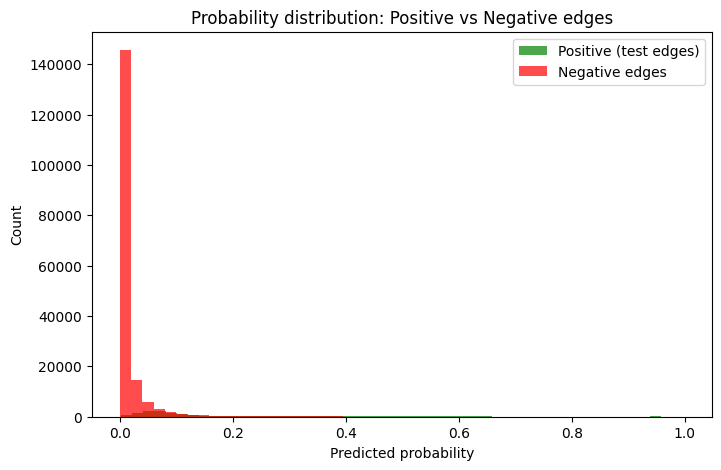

In [42]:
import matplotlib.pyplot as plt

def plot_probability_distribution(G_train, test_edges, embeddings, clf, neg_multiplier=10):
    """
    Plot predicted probabilities for positive (test) edges vs negative edges.
    """
    # Sample negatives
    num_neg = len(test_edges) * neg_multiplier
    neg_edges = sample_negative_edges(G_train, num_neg)

    X, y = [], []
    for u, v in test_edges:
        if u in embeddings and v in embeddings:
            X.append(hadamard(embeddings[u], embeddings[v]))
            y.append(1)
    for u, v in neg_edges:
        if u in embeddings and v in embeddings:
            X.append(hadamard(embeddings[u], embeddings[v]))
            y.append(0)

    probs = clf.predict_proba(np.array(X))[:,1]
    probs_pos = [p for p,l in zip(probs, y) if l==1]
    probs_neg = [p for p,l in zip(probs, y) if l==0]

    # Plot histogram
    plt.figure(figsize=(8,5))
    plt.hist(probs_pos, bins=50, alpha=0.7, label='Positive (test edges)', color='green')
    plt.hist(probs_neg, bins=50, alpha=0.7, label='Negative edges', color='red')
    plt.xlabel('Predicted probability')
    plt.ylabel('Count')
    plt.title('Probability distribution: Positive vs Negative edges')
    plt.legend()
    plt.show()

# Example usage:
plot_probability_distribution(G_train, test_edges, embeddings, clf, neg_multiplier=10)


In [ ]:
import numpy as np
import networkx as nx
import random
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

# -----------------------------
# Feature function
# -----------------------------
def hadamard(u_emb, v_emb):
    return u_emb * v_emb

# -----------------------------
# Negative edge sampler
# -----------------------------
def sample_negative_edges(G, num_samples):
    nodes = list(G.nodes())
    neg_edges = set()
    while len(neg_edges) < num_samples:
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v):
            neg_edges.add((u, v))
    return list(neg_edges)




# -----------------------------
# Train link predictor
# -----------------------------
def train_link_predictor(G, embeddings, pos_edges, neg_ratio=5):
    X, y = [], []
    # Positive edges
    for u, v in pos_edges:
        if u in embeddings and v in embeddings:
            X.append(hadamard(embeddings[u], embeddings[v]))
            y.append(1)
    # Negative edges
    neg_edges = sample_negative_edges(G, len(X) * neg_ratio)
    for u, v in neg_edges:
        if u in embeddings and v in embeddings:
            X.append(hadamard(embeddings[u], embeddings[v]))
            y.append(0)

    clf = SGDClassifier(loss="log_loss", max_iter=5, tol=1e-3)
    clf.fit(np.array(X), np.array(y))
    return clf


def predict_top_k_edges_vectorized(G, embeddings, clf, K=10, candidate_ratio=5):
    """
    Predict top K missing edges efficiently for graphs of any size.
    - candidate_ratio: number of candidate non-edges relative to |E|
    """
    nodes = list(G.nodes())
    num_candidates = candidate_ratio * G.number_of_edges()
    
    # Efficiently generate candidate non-edges
    all_non_edges = [(u, v) for u in nodes for v in nodes if u < v and not G.has_edge(u, v)]
    
    if len(all_non_edges) == 0:
        return []
    
    # Sample candidates if graph is large
    if len(all_non_edges) > num_candidates:
        candidates = random.sample(all_non_edges, num_candidates)
    else:
        candidates = all_non_edges
    
    # Vectorized Hadamard features
    u_nodes, v_nodes = zip(*candidates)
    u_embs = np.array([embeddings[u] for u in u_nodes])
    v_embs = np.array([embeddings[v] for v in v_nodes])
    X_candidate = hadamard(u_embs, v_embs)
    
    # Predict probabilities
    probs = clf.predict_proba(X_candidate)[:, 1]
    
    # Get top K edges
    top_indices = np.argsort(probs)[::-1][:K]
    top_edges = [(u_nodes[i], v_nodes[i], probs[i]) for i in top_indices]
    return top_edges




In [29]:
from sklearn.metrics import roc_auc_score

def evaluate_on_test_set(G_train, test_edges, embeddings, clf, K=10, candidate_ratio=5):
    """
    Evaluate link predictor on held-out test edges.
    - G_train: the training graph (for sampling negative edges only)
    - test_edges: held-out edges (ground truth for evaluation)
    - embeddings: node embeddings
    - clf: trained classifier
    - K: top-K edges for Precision@K
    """
    # -------------------------
    # ROC-AUC
    # -------------------------
    num_neg = len(test_edges)
    # Sample negatives that are not in train or test edges
    neg_edges = sample_negative_edges(G_train, num_neg)

    X, y = [], []
    for u, v in test_edges:
        if u in embeddings and v in embeddings:
            X.append(hadamard(embeddings[u], embeddings[v]))
            y.append(1)
    for u, v in neg_edges:
        if u in embeddings and v in embeddings:
            X.append(hadamard(embeddings[u], embeddings[v]))
            y.append(0)

    probs = clf.predict_proba(np.array(X))[:, 1]
    auc = roc_auc_score(y, probs)

    # -------------------------
    # Precision@K / Recall@K / F1@K
    # -------------------------
    # Candidates = test edges + some negative edges
    num_candidates = candidate_ratio * len(test_edges)
    sampled_negatives = sample_negative_edges(G_train, num_candidates)
    candidates = sampled_negatives + test_edges

    u_nodes, v_nodes = zip(*candidates)
    X_candidate = [hadamard(embeddings[u], embeddings[v])
                   for u, v in candidates if u in embeddings and v in embeddings]

    probs = clf.predict_proba(np.array(X_candidate))[:, 1]
    top_indices = np.argsort(probs)[::-1][:K]
    top_edges = [candidates[i] for i in top_indices]

    true_positives = sum(1 for e in top_edges if e in test_edges)
    precision = true_positives / K
    recall = true_positives / len(test_edges)
    f1 = 0 if precision + recall == 0 else 2 * precision * recall / (precision + recall)

    return {
        "ROC-AUC": auc,
        f"Precision@{K}": precision,
        f"Recall@{K}": recall,
        f"F1@{K}": f1
    }


In [ ]:
# Graph + embeddings
G = nx.read_edgelist(graph_path)
embeddings = load_embeddings(emb_path)

# Split into train/test edges
G_train, train_edges, test_edges = train_test_split_edges(G, test_frac=0.2)

# Train classifier
clf = train_link_predictor(G_train, embeddings, train_edges, neg_ratio=5)

# Evaluate
results = evaluate_on_test_set(G_train, test_edges, embeddings, clf, K=10, candidate_ratio=5)
print("ROC-AUC:", results["ROC-AUC"])
print("Precision@10:", results["Precision@10"])





/home/ofrie.r/miniconda3/envs/snap_env/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


ROC-AUC: 0.9497718080811246
Precision@10: 1.0


In [37]:

# Get top-K predicted edges
top_edges = predict_top_k_edges_vectorized(G_train, embeddings, clf, K=10, candidate_ratio=5)

print("Top 10 predicted edges with probabilities:")
for u, v, p in top_edges:
    in_test = (u, v) in test_edges or (v, u) in test_edges  # check both directions
    print(f"{u}-{v}: {p:.4f} | In test set: {in_test}")

Top 10 predicted edges with probabilities:
3318-3382: 1.0000 | In test set: True
2889-3382: 1.0000 | In test set: True
2834-3382: 1.0000 | In test set: False
2889-3008: 1.0000 | In test set: True
2889-3318: 1.0000 | In test set: True
2670-2834: 1.0000 | In test set: True
3579-3701: 1.0000 | In test set: True
2767-3423: 1.0000 | In test set: False
1378-1533: 1.0000 | In test set: True
776-870: 1.0000 | In test set: False


In [15]:
import numpy as np
import networkx as nx
from sklearn.linear_model import LogisticRegression
import random

def hadamard_batch(u_embeddings, v_embeddings):
    """Element-wise multiplication of two arrays of embeddings."""
    return u_embeddings * v_embeddings

def load_embeddings(path):
    embeddings = {}
    with open(path, 'r') as f:
        header = f.readline()  # skip first line
        for line in f:
            parts = line.strip().split()
            if len(parts) < 2: continue
            node = parts[0]
            vec = np.array([float(x) for x in parts[1:]])
            embeddings[node] = vec
    return embeddings

def train_link_predictor(G, embeddings, neg_ratio=1):
    """Train classifier on edges and sampled negative edges."""
    X, y = [], []
    nodes = list(G.nodes())
    
    # Positive edges
    for u, v in G.edges():
        if u in embeddings and v in embeddings:
            X.append(hadamard_batch(embeddings[u], embeddings[v]))
            y.append(1)
    
    # Negative edges (sampled)
    num_neg = len(X) * neg_ratio
    neg_edges = set()
    nodes_array = np.array(nodes)
    while len(neg_edges) < num_neg:
        u, v = np.random.choice(nodes_array, 2, replace=False)
        if not G.has_edge(u, v) and (u, v) not in neg_edges:
            if u in embeddings and v in embeddings:
                X.append(hadamard_batch(embeddings[u], embeddings[v]))
                y.append(0)
                neg_edges.add((u, v))
    
    clf = LogisticRegression(max_iter=1000)
    clf.fit(np.array(X), np.array(y))
    return clf

def predict_top_k_edges_vectorized(G, embeddings, clf, K=10, candidate_ratio=5):
    """
    Predict top K missing edges efficiently for graphs of any size.
    - candidate_ratio: number of candidate non-edges relative to |E|
    """
    nodes = list(G.nodes())
    num_candidates = candidate_ratio * G.number_of_edges()
    
    # Efficiently generate candidate non-edges
    all_non_edges = [(u, v) for u in nodes for v in nodes if u < v and not G.has_edge(u, v)]
    
    if len(all_non_edges) == 0:
        return []
    
    # Sample candidates if graph is large
    if len(all_non_edges) > num_candidates:
        candidates = random.sample(all_non_edges, num_candidates)
    else:
        candidates = all_non_edges
    
    # Vectorized Hadamard features
    u_nodes, v_nodes = zip(*candidates)
    u_embs = np.array([embeddings[u] for u in u_nodes])
    v_embs = np.array([embeddings[v] for v in v_nodes])
    X_candidate = hadamard_batch(u_embs, v_embs)
    
    # Predict probabilities
    probs = clf.predict_proba(X_candidate)[:, 1]
    
    # Get top K edges
    top_indices = np.argsort(probs)[::-1][:K]
    top_edges = [(u_nodes[i], v_nodes[i], probs[i]) for i in top_indices]
    return top_edges




In [16]:
# USAGE EXAMPLE
G = nx.read_edgelist(graph_path)
embeddings = load_embeddings(emb_path)

# Train the classifier
clf = train_link_predictor(G, embeddings)

# Predict top K missing edges
top_edges = predict_top_k_edges_vectorized(G, embeddings, clf, K=5)

print("Top 5 predicted edges:")
for u, v, p in top_edges:
    print(f"{u}-{v} : probability {p:.4f}")


Top 5 predicted edges:
2834-3382 : probability 1.0000
3283-3311 : probability 1.0000
3311-3314 : probability 1.0000
874-877 : probability 1.0000
3675-3918 : probability 1.0000


In [ ]:
# 2. Convert GML to edge list without {}
# Load the dolphins GML file
G_dolphins = nx.read_gml("../datasets/dolphins/dolphins.gml")

# Save as edge list without the {} attribute dictionary
nx.write_edgelist(G_dolphins, "../datasets/dolphins/dolphins_clean.edgelist", data=False)

print("Saved dolphins_clean.edgelist without {}")


Saved dolphins_clean.edgelist without {}


In [ ]:
# run the trained model on the actual graph you want to predict edges for
emb_ = load_embeddings("../snap/examples/node2vec/emb/karate.emb")
graph_ = nx.read_edgelist("../snap/examples/node2vec/graph/karate.edgelist", nodetype=str)
top_edges_new = predict_top_k_edges_vectorized(graph_, emb_, clf, K=10)

print("Top 10 predicted edges for the new graph:")
for u, v, p in top_edges_new:
    print(f"{u}-{v} : probability {p:.4f}")


Top 10 predicted edges for the new graph:
26-34 : probability 0.5075
17-34 : probability 0.5075
34-7 : probability 0.5056
2-34 : probability 0.5054
11-34 : probability 0.5052
34-8 : probability 0.5051
26-33 : probability 0.5050
17-33 : probability 0.5050
25-34 : probability 0.5045
34-6 : probability 0.5045


In [16]:
# Add the predicted top edges to graph_
# Add the predicted top edges to graph_
for u, v, p in top_edges_new:
    graph_.add_edge(u, v)

# Save the entire graph (with predicted edges) to a new edgelist file
nx.write_edgelist(graph_, "predicted_top_edges.edgelist", data=False)